In [79]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy import stats, signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# F-test

## The amplitudes in the noise are Gaussian distributed.

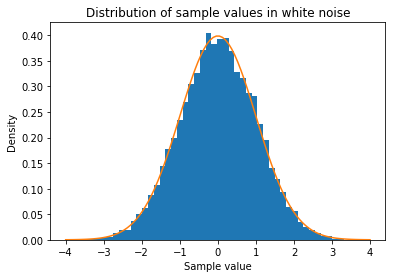

In [2]:
nsamps = 10001
sigma = 1
mean = 0
trace = np.random.normal(mean, sigma, nsamps)
# plot histogram
plt.hist(trace, 50, density=True)
# plot Gaussian
from scipy.stats import norm
# estimate degrees of freedom in data
rv = norm(mean, sigma)
x = np.linspace(mean-4*sigma, mean+4*sigma, 100)
plt.plot(x,rv.pdf(x))
plt.xlabel('Sample value')
plt.ylabel('Density')
plt.title('Distribution of sample values in white noise')
plt.show()

## The energy in the noise is chi-squared distributed.

$Q\ =\sum _{i=1}^{k}Z_{i}^{2}$

$Q \sim \chi ^2_k$

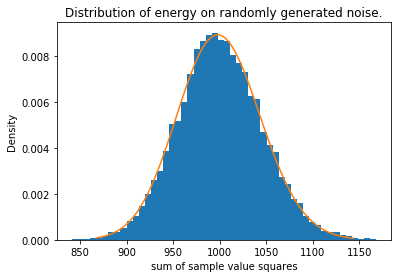

In [3]:
nsamps = 1001
mean = 0
sigma = 1
energy = [ np.sum(np.random.normal(mean, sigma, nsamps)**2) for _ in range(10000) ]
plt.hist(energy, 50, density=True)
plt.title('Distribution of energy on randomly generated noise.')
plt.xlabel('sum of sample value squares')
plt.ylabel('Density')
from scipy.stats import chi2
# estimate degrees of freedom in data
trace = np.random.normal(mean, sigma, nsamps)
df = nsamps - 1
rv = chi2(df)
x = np.linspace(rv.ppf(0.001),rv.ppf(0.999), 100)
plt.plot(x, rv.pdf(x))
plt.show()

# This ratio is related to an F-distribution

$\frac{\lambda_2}{\lambda_2^{min}} \le 1 + \frac{k}{n-k}F^{1-\alpha}_{k,n-k}$

k is the number of parameters which is 2.
n is the degrees of freedom which is calculated from the data.



/Users/jackwalpole/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


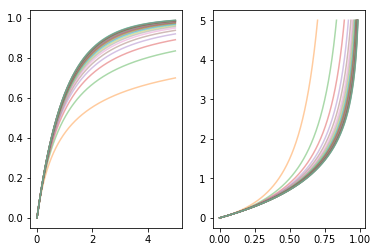

In [334]:
# Some F distributions

x = np.linspace(0,5,1000)

for df in np.arange(30) :
    
    f = stats.f.cdf(x, 2, df)
    plt.subplot(1,2,1)
    plt.plot(x, f, alpha=0.4)
    plt.subplot(1,2,2)
    plt.plot(f, x, alpha=0.4)
    
plt.show()
    


In [315]:
stats.f.cdf

In [344]:

a = sw.SplitWave(split=(30,1.2), noise=0.01).Py()
lam1, lam2 = sw.core.core.covmap2eigvals(a._covmap)


    SCfast   SCdfast     SClag    SCdlag    XCfast   XCdfast     XClag    XCdlag         Q        SI
     32.00      0.00      1.20      0.00     40.00      0.00      1.10      0.00      0.72     -0.07


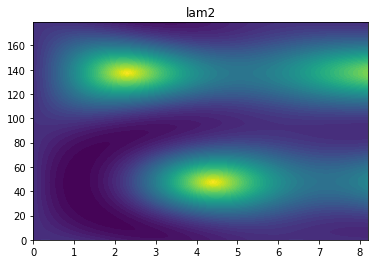

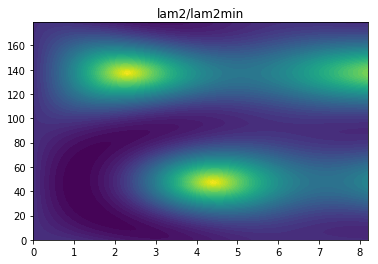

In [345]:
r = lam2 / np.min(lam2)
dd, ll = a._grid

plt.contourf(dd, ll, lam2, 50)
plt.title('lam2')
plt.show()

plt.contourf(dd, ll, r, 50)
plt.title('lam2/lam2min')
plt.show()

In [277]:
ndf = a.sc.ndf

In [278]:
def ftest(lam2, ndf, alpha=0.05):
    """
    returns lambda2 value at 100(1-alpha)% confidence interval
    by default alpha = 0.05 = 95% confidence interval
    following Silver and Chan (1991)
    """
    
    # check ndf is big enough
    if ndf < 3:
        raise Exception('Number of degrees of freedom is less than 3.  \
        This likely indicates a problem which would lead to a spurious measurement.  \
        Check window length.  Check data are demeaned.  Check frequency content.')
    
    lam2min = lam2.min()
    k = 2 # two parameters, phi and dt.
    F = stats.f.ppf(1-alpha,k,ndf)
    lam2alpha = lam2min * ( 1 + (k/(ndf-k)) * F)
    return lam2alpha    

In [279]:
ftest(lam2, ndf)

4.4477392646213062e-06

In [280]:
def fsurf(lam2, ndf, alpha=0.05):
    """
    returns lambda2 value at 100(1-alpha)% confidence interval
    by default alpha = 0.05 = 95% confidence interval
    following Silver and Chan (1991)
    """
    
    # check ndf is big enough
    if ndf < 3:
        raise Exception('Number of degrees of freedom is less than 3.  \
        This likely indicates a problem which would lead to a spurious measurement.  \
        Check window length.  Check data are demeaned.  Check frequency content.')
    k = 2   
    r = ((ndf - k)/k) * ((lam2 / lam2.min()) - 1)
    return stats.f.cdf(r, k, ndf)
#     lam2min = lam2.min()
#     k = 2 # two parameters, phi and dt.
#     F = stats.f.ppf(1-alpha,k,ndf)
#     lam2alpha = lam2min * ( 1 + (k/(ndf-k)) * F)
#     return lam2alpha 

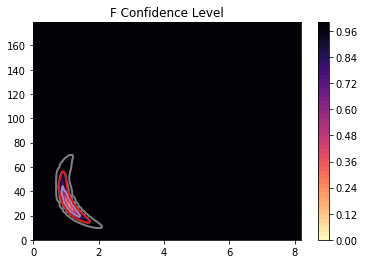

In [283]:
f = fsurf(lam2, ndf)
plt.contourf(dd, ll, f, 50, cmap='magma_r')
plt.colorbar()
# lines at 1-sigma, 2-sigma, 3-sigma.
# plt.contour(dd,ll, f, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.contour(dd,ll, f, levels=[0.68,0.95, 0.997], colors='w', linewidths=2, alpha=0.5)
plt.title('F Confidence Level')

lam295 = sw.core.core.ftest(lam2, ndf)
plt.contour(dd, ll, lam2, levels=[lam295], colors='r')

plt.show()

Fisher transform for correlation coefficients.

/Users/jackwalpole/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


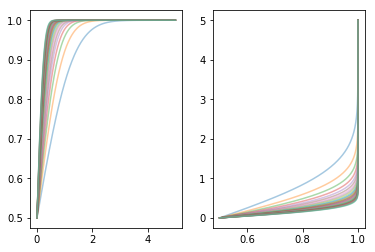

In [380]:
# Some normal distributions

x = np.linspace(0,5,1000)

for df in np.arange(30)+1 :
    
    se = 1/math.sqrt(df)
    f = stats.norm.cdf(x, scale=se)
    plt.subplot(1,2,1)
    plt.plot(x, f, alpha=0.4)
    plt.subplot(1,2,2)
    plt.plot(f, x, alpha=0.4)
    
plt.show()
    

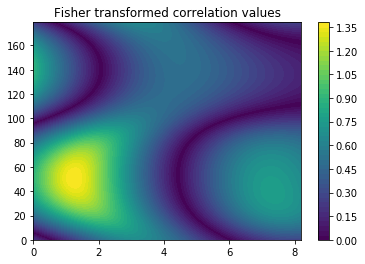

In [384]:
f = sw.core.core.fisher_r(a.xc.vals)
# f = fsurf(lam2, ndf)
plt.contourf(dd, ll, f, 50)
# lines at 1-sigma, 2-sigma, 3-sigma.
# plt.contour(dd,ll, f, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.title('Fisher transformed correlation values')
plt.colorbar()
plt.show()

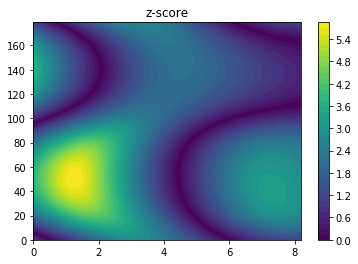

In [385]:
# def zscore(f, ndf):
#     return np.abs((f - f.max())) * math.sqrt(ndf)

def zscore(f, ndf):
    return np.abs(f) * math.sqrt(ndf)



z = zscore(f, ndf)
# f = fsurf(lam2, ndf)
plt.contourf(dd, ll, z, 50)
# lines at 1-sigma, 2-sigma, 3-sigma.
# plt.contour(dd,ll, f, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.title('z-score')
plt.colorbar()
plt.show()

In [386]:
def zsurf(z, ndf):
    """
    returns lambda2 value at 100(1-alpha)% confidence interval
    by default alpha = 0.05 = 95% confidence interval
    following Silver and Chan (1991)
    """
    
    # check ndf is big enough
    if ndf < 3:
        raise Exception('Number of degrees of freedom is less than 3.  \
        This likely indicates a problem which would lead to a spurious measurement.  \
        Check window length.  Check data are demeaned.  Check frequency content.')

    se = 1 / math.sqrt(ndf-3)
    return stats.norm.cdf(z, loc=0, scale=se)

# x = np.linspace(-10,10,1000)
# se = 1 / math.sqrt(ndf)
# plt.plot(x, stats.norm.cdf(x, scale=se))
# plt.show()

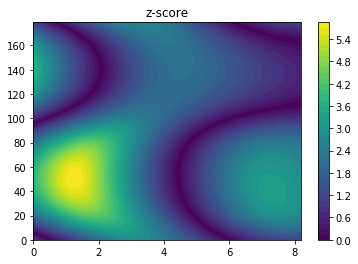

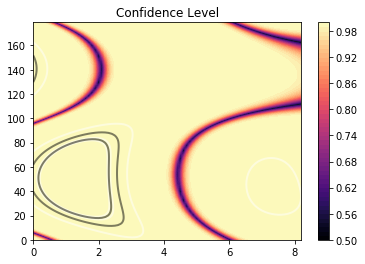

In [390]:
plt.contourf(dd, ll, z, 50)
# lines at 1-sigma, 2-sigma, 3-sigma.
# plt.contour(dd,ll, zs, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.title('z-score')
plt.colorbar()
plt.show()

zs = zsurf(z, ndf)
plt.contourf(dd, ll, zs, 50, cmap='magma')
plt.colorbar()
# lines at 1-sigma, 2-sigma, 3-sigma.
plt.contour(dd,ll, f, levels=[0.68,0.95, 0.997], colors='w', linewidths=2, alpha=0.5)
plt.contour(dd,ll, f, levels=[0.84,0.975], colors='k', linewidths=2, alpha=0.5)
# plt.contour(dd,ll, zs, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.title('Confidence Level')

plt.show()

In [296]:
stats.norm.pdf?

# T-test

In [125]:
def tscore(rho, ndf):
    return rho * np.sqrt(ndf/(1-rho**2))

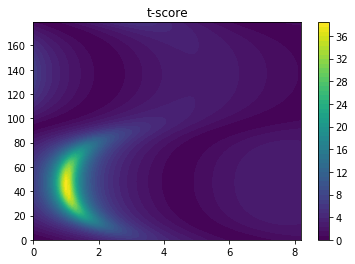

In [191]:
t = tscore(a.xc.vals, a.xc.ndf)
plt.contourf(dd, ll, t, 50)
# lines at 1-sigma, 2-sigma, 3-sigma.
# plt.contour(dd,ll, f, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.title('t-score')
plt.colorbar()
plt.show()

In [203]:
def tconf(t, ndf):
    return stats.t.pdf(t, df=ndf)

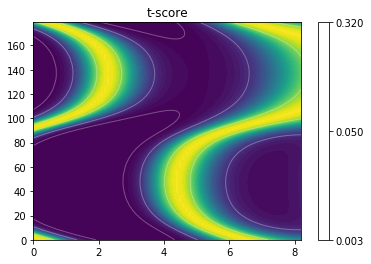

In [205]:
ts = tconf(t, a.xc.ndf)
plt.contourf(dd, ll, ts, 50)
# lines at 1-sigma, 2-sigma, 3-sigma.
plt.contour(dd,ll, ts, levels=[0.003,0.05, 0.32], colors='w', linewidths=1, alpha=0.3)
plt.title('t-score')
plt.colorbar()
plt.show()

16.1323121131


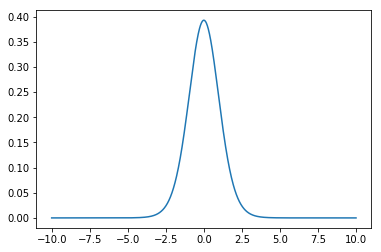

In [206]:
x = np.linspace(-10,10,1000)
print(a.xc.ndf)
plt.plot(x, stats.t.pdf(x, df = a.xc.ndf))
plt.show()

In [174]:
t.max()

38.233311919611587

In [175]:
ndf

34.705665508571123

In [218]:
statistic, pvalue = stats.ttest_1samp(np.ravel(t),0)

In [219]:
statistic.shape

()

In [197]:
np.ravel(t)

array([ 0.58068646,  0.3318334 ,  0.08257605, ...,  0.83237018,
        0.94926604,  1.06949086])

In [220]:
a.xc.vals.min()

0.00011252503754421012

In [309]:
1/math.sqrt(ndf-3)

0.2590408176441643

In [329]:
plt.subplots(2)

(<matplotlib.figure.Figure at 0x1c1a82fcf8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c18d0c438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c18c7cf28>], dtype=object))

    SCfast   SCdfast     SClag    SCdlag    XCfast   XCdfast     XClag    XCdlag         Q        SI
     52.00      0.00      1.30      0.00     51.00      0.00      1.30      0.00      0.97     -0.00


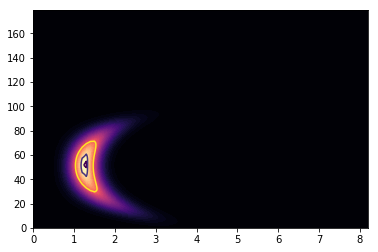

In [366]:
a = sw.SplitWave(noise=0.05, split=[(30,1.2), (56, .5)]).Py()
dd, ll = a._grid
plt.contourf(dd, ll, a.sc.f_cdf, 50, cmap='magma_r')
plt.contour(dd, ll, a.sc.f_cdf, levels=[0.003, 0.05, 0.32])
plt.show()

In [346]:
a._grid

[array([[ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
        [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
        [ 0.2,  0.2,  0.2, ...,  0.2,  0.2,  0.2],
        ..., 
        [ 8. ,  8. ,  8. , ...,  8. ,  8. ,  8. ],
        [ 8.1,  8.1,  8.1, ...,  8.1,  8.1,  8.1],
        [ 8.2,  8.2,  8.2, ...,  8.2,  8.2,  8.2]]),
 array([[   0.,    1.,    2., ...,  177.,  178.,  179.],
        [   0.,    1.,    2., ...,  177.,  178.,  179.],
        [   0.,    1.,    2., ...,  177.,  178.,  179.],
        ..., 
        [   0.,    1.,    2., ...,  177.,  178.,  179.],
        [   0.,    1.,    2., ...,  177.,  178.,  179.],
        [   0.,    1.,    2., ...,  177.,  178.,  179.]])]

In [391]:
plt.scatter(a.x, a.y)
plt.show()

AttributeError: 'Py' object has no attribute '_SplitWave__x'

    SCfast   SCdfast     SClag    SCdlag    XCfast   XCdfast     XClag    XCdlag         Q        SI
     65.00      0.00      3.00      0.00     65.00      0.00      3.00      0.00      1.00      0.53


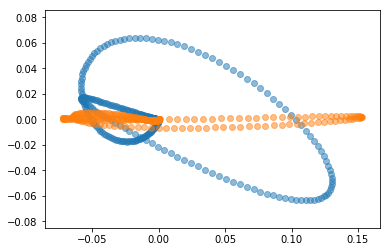

In [422]:
a = sw.SplitWave(noise=0.0001,split=[(30,1.2),(60,1.2),(90,1.)]).Py()
d = a._data.chop()
plt.scatter(d.x, d.y, alpha=0.5)
e = a.sc.data_corr.chop()
plt.scatter(e.x, e.y, alpha=0.5)
plt.show()

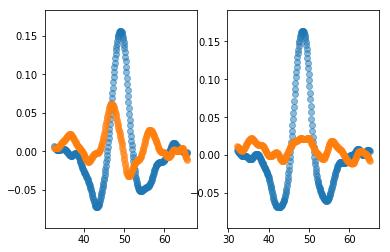

In [415]:
plt.subplot(1,2,1)
plt.scatter(d._chopt(), d.x, alpha=0.5)
plt.scatter(d._chopt(), d.y, alpha=0.5)
plt.subplot(1,2,2)
plt.scatter(e._chopt(), e.x, alpha=0.5)
plt.scatter(e._chopt(), e.y, alpha=0.5)
plt.show()


In [412]:
a._data._chopt()

array([ 32.8,  32.9,  33. ,  33.1,  33.2,  33.3,  33.4,  33.5,  33.6,
        33.7,  33.8,  33.9,  34. ,  34.1,  34.2,  34.3,  34.4,  34.5,
        34.6,  34.7,  34.8,  34.9,  35. ,  35.1,  35.2,  35.3,  35.4,
        35.5,  35.6,  35.7,  35.8,  35.9,  36. ,  36.1,  36.2,  36.3,
        36.4,  36.5,  36.6,  36.7,  36.8,  36.9,  37. ,  37.1,  37.2,
        37.3,  37.4,  37.5,  37.6,  37.7,  37.8,  37.9,  38. ,  38.1,
        38.2,  38.3,  38.4,  38.5,  38.6,  38.7,  38.8,  38.9,  39. ,
        39.1,  39.2,  39.3,  39.4,  39.5,  39.6,  39.7,  39.8,  39.9,
        40. ,  40.1,  40.2,  40.3,  40.4,  40.5,  40.6,  40.7,  40.8,
        40.9,  41. ,  41.1,  41.2,  41.3,  41.4,  41.5,  41.6,  41.7,
        41.8,  41.9,  42. ,  42.1,  42.2,  42.3,  42.4,  42.5,  42.6,
        42.7,  42.8,  42.9,  43. ,  43.1,  43.2,  43.3,  43.4,  43.5,
        43.6,  43.7,  43.8,  43.9,  44. ,  44.1,  44.2,  44.3,  44.4,
        44.5,  44.6,  44.7,  44.8,  44.9,  45. ,  45.1,  45.2,  45.3,
        45.4,  45.5,